# Homework and bake-off: pragmatic color descriptions

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2020"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [All two-word examples as a dev corpus](#All-two-word-examples-as-a-dev-corpus)
1. [Dev dataset](#Dev-dataset)
1. [Random train–test split for development](#Random-train–test-split-for-development)
1. [Question 1: Improve the tokenizer [1 point]](#Question-1:-Improve-the-tokenizer-[1-point])
1. [Use the tokenizer](#Use-the-tokenizer)
1. [Question 2: Improve the color representations [1 point]](#Question-2:-Improve-the-color-representations-[1-point])
1. [Use the color representer](#Use-the-color-representer)
1. [Initial model](#Initial-model)
1. [Question 3: GloVe embeddings [1 points]](#Question-3:-GloVe-embeddings-[1-points])
1. [Try the GloVe representations](#Try-the-GloVe-representations)
1. [Question 4: Color context [3 points]](#Question-4:-Color-context-[3-points])
1. [Your original system [3 points]](#Your-original-system-[3-points])
1. [Bakeoff [1 point]](#Bakeoff-[1-point])

## Overview

This homework and associated bake-off are oriented toward building an effective system for generating color descriptions that are pragmatic in the sense that they would help a reader/listener figure out which color was being referred to in a shared context consisting of a target color (whose identity is known only to the describer/speaker) and a set of distractors.

The notebook [colors_overview.ipynb](colors_overview.ipynb) should be studied before work on this homework begins. That notebook provides backgroud on the task, the dataset, and the modeling code that you will be using and adapting.

The homework questions are more open-ended than previous ones have been. Rather than asking you to implement pre-defined functionality, they ask you to try to improve baseline components of the full system in ways that you find to be effective. As usual, this culiminates in a prompt asking you to develop a novel system for entry into the bake-off. In this case, though, the work you do for the homework will likely be directly incorporated into that system.

## Set-up

See [colors_overview.ipynb](colors_overview.ipynb) for set-up in instructions and other background details.

In [3]:
from colors import ColorsCorpusReader
import os
from sklearn.model_selection import train_test_split
from torch_color_describer import (
    ColorizedNeuralListener, create_example_dataset)
import utils
from utils import START_SYMBOL, END_SYMBOL, UNK_SYMBOL
import numpy as np

In [4]:
utils.fix_random_seeds()

In [5]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv")

## All two-word examples as a dev corpus

So that you don't have to sit through excessively long training runs during development, I suggest working with the two-word-only subset of the corpus until you enter into the late stages of system testing.

In [6]:
dev_corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME, 
    word_count=None, 
    normalize_colors=True)

In [7]:
dev_examples = list(dev_corpus.read())

This subset has about one-third the examples of the full corpus:

In [6]:
len(dev_examples)

46994

We __should__ worry that it's not a fully representative sample. Most of the descriptions in the full corpus are shorter, and a large proportion are longer. So this dataset is mainly for debugging, development, and general hill-climbing. All findings should be validated on the full dataset at some point.

## Dev dataset

The first step is to extract the raw color and raw texts from the corpus:

In [8]:
dev_rawcols, dev_texts = zip(*[[ex.colors, ex.contents] for ex in dev_examples])

The raw color representations are suitable inputs to a model, but the texts are just strings, so they can't really be processed as-is. Question 1 asks you to do some tokenizing!

## Random train–test split for development

For the sake of development runs, we create a random train–test split:

In [9]:
dev_rawcols_train, dev_rawcols_test, dev_texts_train, dev_texts_test = \
    train_test_split(dev_rawcols, dev_texts)

## Question 1: Improve the tokenizer [1 point]

This is the first required question – the first required modification to the default pipeline.

The function `tokenize_example` simply splits its string on whitespace and adds the required start and end symbols:

In [10]:
from colors_utils import heuristic_ending_tokenizer

def tokenize_example(s):
    
    # Improve me!
    
    return [START_SYMBOL] + heuristic_ending_tokenizer(s) + [END_SYMBOL]

def clean_test_and_training(dev_seqs_train, dev_seqs_test):    
    vocab = {}
    for toks in dev_seqs_train+dev_seqs_test:
        for w in toks:
            if w not in vocab:
                vocab[w]=0
            vocab[w]+=1
    removal_candidates = {k:v for k, v in vocab.items() if v == 1 }
    
    dev_seqs_train = [[w if w not in removal_candidates else UNK_SYMBOL for w in toks] for toks in dev_seqs_train]

    dev_seqs_test = [[w if w not in removal_candidates else UNK_SYMBOL for w in toks] for toks in dev_seqs_test]
    return dev_seqs_train, dev_seqs_test

In [11]:
tokenize_example(dev_texts_train[376])

['<s>', 'aqua', '</s>']

__Your task__: Modify `tokenize_example` so that it does something more sophisticated with the input text. 

__Notes__:

* There are useful ideas for this in [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142)
* There is no requirement that you do word-level tokenization. Sub-word and multi-word are options.
* This question can interact with the size of your vocabulary (see just below), and in turn with decisions about how to use `UNK_SYMBOL`.

__Important__: don't forget to add the start and end symbols, else the resulting models will definitely be terrible!

## Use the tokenizer

Once the tokenizer is working, run the following cell to tokenize your inputs:

In [12]:
dev_seqs_train = [tokenize_example(s) for s in dev_texts_train]

dev_seqs_test = [tokenize_example(s) for s in dev_texts_test]

dev_seqs_train, dev_seqs_test = clean_test_and_training(dev_seqs_train, dev_seqs_test)

We use only the train set to derive a vocabulary for the model:

In [13]:
dev_vocab = sorted({w for toks in dev_seqs_train for w in toks}) + [UNK_SYMBOL]

It's important that the `UNK_SYMBOL` is included somewhere in this list. Test examples with word not seen in training will be mapped to `UNK_SYMBOL`. If you model's vocab is the same as your train vocab, then `UNK_SYMBOL` will never be encountered during training, so it will be a random vector at test time.

In [14]:
len(dev_vocab)

1551

## Question 2: Improve the color representations [1 point]

This is the second required pipeline improvement for the assignment. 

The following functions do nothing at all to the raw input colors we get from the corpus. 

In [31]:
import colorsys

def represent_color_context(colors):
    
    # Improve me!
    
    return [represent_color(color) for color in colors]


def represent_color(color):
    import numpy.fft as fft
    # Improve me!
    #return color
#     color_hsv = colorsys.rgb_to_hsv(*color)
    return fft.fft(color).real
#     return colorsys.rgb_to_hsv(*color)

def fft_color_to_rgb(fft_color):
    import numpy.fft as fft
    import numpy as np
    return np.real(fft.ifft(fft_color))

In [32]:
fft_colors = represent_color_context(dev_rawcols_train[0])

print('-- Original')
print(dev_rawcols_train[0])
print('-- FFT')
print(fft_colors)
print('-- Back to original')
print(fft_color_to_rgb(fft_colors))

-- Original
[[0.8583333333333333, 0.5, 0.72], [0.15, 0.5, 0.23], [0.575, 0.5, 0.07]]
-- FFT
[array([2.07833333, 0.24833333, 0.24833333]), array([ 0.88 , -0.215, -0.215]), array([1.145, 0.29 , 0.29 ])]
-- Back to original
[[0.85833333 0.61       0.61      ]
 [0.15       0.365      0.365     ]
 [0.575      0.285      0.285     ]]


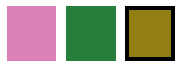

In [33]:
from colors import draw_rgb_colors, draw_fft_colors
draw_rgb_colors(dev_rawcols_train[0], 2)

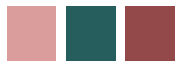

In [34]:
draw_fft_colors(fft_colors)

__Your task__: Modify `represent_color_context` and/or `represent_color` to represent colors in a new way.
    
__Notes__:

* The Fourier-transform method of [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142) is a proven choice.
* You are not required to keep `represent_color`. This might be unnatural if you want to perform an operation on each color trio all at once.
* For that matter, if you want to process all of the color contexts in the entire data set all at once, that is fine too, as long as you can also perform the operation at test time with an unknown number of examples being tested.

## Use the color representer

The following cell just runs your `represent_color_context` on the train and test sets:

In [66]:
dev_cols_train = [represent_color_context(colors) for colors in dev_rawcols_train]

dev_cols_test = [represent_color_context(colors) for colors in dev_rawcols_test]

At this point, our preprocessing steps are complete, and we can fit a first model.

## Initial model

The first model is configured right now to be a small model run for just a few iterations. It should be enough to get traction, but it's unlikely to be a great model. You are free to modify this configuration if you wish; it is here just for demonstration and testing:

In [67]:
dev_mod = ColorizedNeuralListener(
    dev_vocab, 
    embed_dim=10, 
    hidden_dim=10, 
    max_iter=5, 
    batch_size=128)

Using cpu


In [68]:
_ = dev_mod.fit(dev_cols_train, dev_seqs_train)

ColorizedNeuralListenerEncoder cpu
ColorizedNeuralListenerEncoderDecoder cpu


/Users/55mb/Documents/Courses/xcs224u/final_project/cs224u/torch_color_describer.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  color_seqs = torch.FloatTensor(color_seqs)


Train: Epoch 1; err = 255.2325730919838; time = 8.816678047180176
Train: Epoch 2; err = 232.16912704706192; time = 9.642733812332153
Train: Epoch 3; err = 223.25770688056946; time = 9.62045693397522
Train: Epoch 4; err = 218.35947579145432; time = 9.871763944625854
Train: Epoch 5; err = 214.46475839614868; time = 10.227066040039062


We can also see the model's predicted sequences given color context inputs:

In [69]:
dev_mod.predict(dev_cols_test[:1], dev_seqs_train[:1])

[1]

As discussed in [colors_overview.ipynb](colors_overview.ipynb), our primary metric is `listener_accuracy`:

In [32]:
#dev_mod.listener_accuracy(dev_cols_test, dev_seqs_test)

In [22]:
#dev_seqs_train[:1]

## Question 3: GloVe embeddings [1 points]

The above model uses a random initial embedding, as configured by the decoder used by `ContextualColorDescriber`. This homework question asks you to consider using GloVe inputs. 

__Your task__: Complete `create_glove_embedding` so that it creates a GloVe embedding based on your model vocabulary. This isn't mean to be analytically challenging, but rather just to create a basis for you to try out other kinds of rich initialization.

In [70]:
GLOVE_HOME = os.path.join('data', 'glove.6B')

In [71]:
def create_glove_embedding(vocab, glove_base_filename='glove.6B.100d.txt'):
    
    # Use `utils.glove2dict` to read in the GloVe file:    
    ##### YOUR CODE HERE
    glove_dict = utils.glove2dict(os.path.join(GLOVE_HOME, glove_base_filename))

    
    # Use `utils.create_pretrained_embedding` to create the embedding.
    # This function will, by default, ensure that START_TOKEN, 
    # END_TOKEN, and UNK_TOKEN are included in the embedding.
    ##### YOUR CODE HERE
    embedding, new_vocab = utils.create_pretrained_embedding(glove_dict, vocab)

    
    # Be sure to return the embedding you create as well as the
    # vocabulary returned by `utils.create_pretrained_embedding`,
    # which is likely to have been modified from the input `vocab`.
    
    ##### YOUR CODE HERE
    return embedding, new_vocab


## Try the GloVe representations

Let's see if GloVe helped for our development data:

In [25]:
#dev_glove_embedding, dev_glove_vocab = create_glove_embedding(dev_vocab)

In [72]:
embedding = np.random.normal(
            loc=0, scale=0.01, size=(len(dev_vocab), 100))

The above might dramatically change your vocabulary, depending on how many items from your vocab are in the Glove space:

## Question 4: Color context [3 points]

In [73]:
toy_color_seqs, toy_word_seqs, toy_vocab = create_example_dataset(
    group_size=50, vec_dim=2)

In [74]:
toy_color_seqs_train, toy_color_seqs_test, toy_word_seqs_train, toy_word_seqs_test = \
    train_test_split(toy_color_seqs, toy_word_seqs)

In [76]:
toy_mod = ColorizedNeuralListener(
    toy_vocab, 
    embed_dim=100, 
    embedding=embedding,
    hidden_dim=100, 
    max_iter=2, 
    batch_size=128)

Using cpu


In [77]:
_ = toy_mod.fit(toy_color_seqs_train, toy_word_seqs_train)

ColorizedNeuralListenerEncoder cpu
ColorizedNeuralListenerEncoderDecoder cpu
Train: Epoch 1; err = 1.0988975763320923; time = 0.029386281967163086
Train: Epoch 2; err = 1.0941307544708252; time = 0.018450021743774414


In [78]:
preds = toy_mod.predict(toy_color_seqs_test, toy_word_seqs_test)
correct = sum([1 if x == 2 else 0 for x in preds])
print(correct, "/", len(preds), correct/len(preds))

13 / 38 0.34210526315789475


If that worked, then you can now try this model on SCC problems!

In [79]:
dev_color_mod = ColorizedNeuralListener(
    dev_vocab, 
    #embedding=dev_glove_embedding, 
    embed_dim=100,
    embedding=embedding,
    hidden_dim=100, 
    max_iter=10,
    batch_size=64,
    dropout_prob=0.,
    eta=0.005,
    lr_rate=0.96,
    warm_start=True,
    force_cpu=False)

Using cpu


In [80]:
_ = dev_color_mod.fit(dev_cols_train, dev_seqs_train)

ColorizedNeuralListenerEncoder cpu
ColorizedNeuralListenerEncoderDecoder cpu
Train: Epoch 1; err = 541.3919068574905; time = 11.063759803771973
Train: Epoch 2; err = 500.2196434736252; time = 12.451120138168335
Train: Epoch 3; err = 487.11743050813675; time = 12.501605033874512
Train: Epoch 4; err = 466.39636570215225; time = 12.984730958938599
Train: Epoch 5; err = 455.7065489888191; time = 13.331377029418945
Train: Epoch 6; err = 446.74595975875854; time = 13.291994094848633
Train: Epoch 7; err = 448.8879731297493; time = 13.03772497177124
Train: Epoch 8; err = 435.8256126046181; time = 13.455543994903564
Train: Epoch 9; err = 432.8725681900978; time = 13.727197885513306
Train: Epoch 10; err = 428.55587059259415; time = 12.941281795501709


In [81]:
test_preds = dev_color_mod.predict(dev_cols_test, dev_seqs_test)
#dev_color_mod.predict(dev_cols_test, dev_seqs_test, probabilities=True)
train_preds = dev_color_mod.predict(dev_cols_train, dev_seqs_train)
#dev_color_mod.predict(dev_cols_test, dev_seqs_test, probabilities=True)

In [82]:
correct = sum([1 if x == 2 else 0 for x in test_preds])
print("test", correct, "/", len(test_preds), correct/len(test_preds))
correct = sum([1 if x == 2 else 0 for x in train_preds])
print("train", correct, "/", len(train_preds), correct/len(train_preds))

test 8946 / 11749 0.7614265043833518
train 27301 / 35245 0.7746063271386012


In [83]:
hyperparameter_exploration = {
            "batch_medium": {
                "batch_size": 64,
                "dropout_prob": 0.0,
                "eta": 0.005,
                "lr_rate": 0.96,
            },
            "batch_small": {
                "batch_size": 32,
                "dropout_prob": 0.0,
                "eta": 0.005,
                "lr_rate": 0.96,
            },
             "batch_xsmall": {
                "batch_size": 16,
                "dropout_prob": 0.0,
                "eta": 0.005,
                "lr_rate": 0.96,
            },
            "batch_large": {
                "batch_size": 128,
                "dropout_prob": 0.0,
                "eta": 0.005,
                "lr_rate": 0.96,
            },
            "batch_xlarge": {
                "batch_size": 256,
                "dropout_prob": 0.0,
                "eta": 0.005,
                "lr_rate": 0.96,
            },
            "dropout_small": {
                "batch_size": 64,
                "dropout_prob": 0.1,
                "eta": 0.005,
                "lr_rate": 0.96,
            },
            "dropout_large": {
                "batch_size": 64,
                "dropout_prob": 0.3,
                "eta": 0.005,
                "lr_rate": 0.96,
            },
            "eta_small": {
                "batch_size": 64,
                "dropout_prob": 0.0,
                "eta": 0.0005,
                "lr_rate": 0.96,
            },
            "eta_medium": {
                "batch_size": 64,
                "dropout_prob": 0.0,
                "eta": 0.01,
                "lr_rate": 0.96,
            },
            "eta_large": {
                "batch_size": 64,
                "dropout_prob": 0.0,
                "eta": 0.05,
                "lr_rate": 0.96,
            },
            "lr_small": {
                "batch_size": 64,
                "dropout_prob": 0.0,
                "eta": 0.005,
                "lr_rate": 0.05,
            },
            "lr_medium": {
                "batch_size": 64,
                "dropout_prob": 0.0,
                "eta": 0.005,
                "lr_rate": 0.4,
            },
            "lr_large": {
                "batch_size": 64,
                "dropout_prob": 0.0,
                "eta": 0.005,
                "lr_rate": 0.99,
            },
        }

model_exploration = {}
model_fittings = {}
for config in hyperparameter_exploration:
    print(f'\nTraining for config: {config}')
    model_exploration[config] = ColorizedNeuralListener(
        dev_vocab, 
        embed_dim=100,
        embedding=embedding,
        hidden_dim=100, 
        max_iter=100,
        warm_start=True,
        force_cpu=False, **hyperparameter_exploration[config])
    model_fittings[config] = model_exploration[config].fit(dev_cols_train, dev_seqs_train)


Training for config: batch_medium
Using cpu
ColorizedNeuralListenerEncoder cpu
ColorizedNeuralListenerEncoderDecoder cpu
Train: Epoch 1; err = 561.9436583518982; time = 11.563308000564575
Train: Epoch 2; err = 507.93099397420883; time = 11.92100191116333
Train: Epoch 3; err = 482.72451454401016; time = 12.328474760055542
Train: Epoch 4; err = 479.6989526748657; time = 12.582051992416382
Train: Epoch 5; err = 461.16443490982056; time = 12.725441217422485
Train: Epoch 6; err = 451.1033304333687; time = 12.72063398361206
Train: Epoch 7; err = 442.30820244550705; time = 12.571479082107544
Train: Epoch 8; err = 439.45595794916153; time = 12.69946002960205
Train: Epoch 9; err = 446.20853340625763; time = 12.585028171539307
Train: Epoch 10; err = 433.0049625635147; time = 12.838449001312256
Train: Epoch 11; err = 428.5005812048912; time = 12.951405048370361
Train: Epoch 12; err = 428.57429522275925; time = 12.996263980865479
Train: Epoch 13; err = 425.0000900030136; time = 13.967862129211426

Train: Epoch 10; err = 836.9487182497978; time = 17.478610038757324
Train: Epoch 11; err = 830.9658454060555; time = 17.185606956481934
Train: Epoch 12; err = 828.1608707308769; time = 17.74897003173828
Train: Epoch 13; err = 823.4143252372742; time = 18.632197856903076
Train: Epoch 14; err = 819.3946200013161; time = 18.330410957336426
0.0048
tensor([0.1237, 0.1887, 0.6876], grad_fn=<MeanBackward1>) 0.8213493824005127
Train: Epoch 15; err = 814.8883317708969; time = 17.467868328094482
Train: Epoch 16; err = 808.3661930561066; time = 18.139600038528442
Train: Epoch 17; err = 804.2031346559525; time = 18.446974992752075
Train: Epoch 18; err = 802.1678283214569; time = 17.820896863937378
Train: Epoch 19; err = 800.071427166462; time = 16.963726043701172
Train: Epoch 20; err = 796.4901947975159; time = 17.871976852416992
Train: Epoch 21; err = 793.6265470981598; time = 19.601378202438354
Train: Epoch 22; err = 790.50310587883; time = 18.59966278076172
Train: Epoch 23; err = 789.1928251385

Train: Epoch 20; err = 1597.4899680614471; time = 25.05938720703125
Train: Epoch 21; err = 1587.716001033783; time = 26.248860836029053
Train: Epoch 22; err = 1583.0893050432205; time = 30.72833490371704
Train: Epoch 23; err = 1578.1043937206268; time = 26.57053303718567
Train: Epoch 24; err = 1573.059231698513; time = 25.41895318031311
Train: Epoch 25; err = 1575.4251882433891; time = 26.810476064682007
Train: Epoch 26; err = 1572.145947277546; time = 26.216754913330078
Train: Epoch 27; err = 1563.082687139511; time = 27.542160987854004
Train: Epoch 28; err = 1559.6237740516663; time = 27.88184905052185
Train: Epoch 29; err = 1552.6429162621498; time = 28.566699981689453
0.004607999999999999
tensor([0.0802, 0.1561, 0.7637], grad_fn=<MeanBackward1>) 0.7857096195220947
Train: Epoch 30; err = 1552.9706960320473; time = 27.895450830459595
Train: Epoch 31; err = 1545.640117585659; time = 26.835784196853638
Train: Epoch 32; err = 1543.6904818415642; time = 27.5002338886261
Train: Epoch 33; 

0.004607999999999999
tensor([0.1085, 0.0372, 0.8543], grad_fn=<MeanBackward1>) 0.6761501431465149
Train: Epoch 30; err = 205.33666342496872; time = 12.055318117141724
Train: Epoch 31; err = 206.67297673225403; time = 12.1061851978302
Train: Epoch 32; err = 205.36057478189468; time = 12.325638055801392
Train: Epoch 33; err = 203.63458907604218; time = 13.409634113311768
Train: Epoch 34; err = 203.6909146308899; time = 14.14093279838562
Train: Epoch 35; err = 205.06151139736176; time = 13.42496109008789
Train: Epoch 36; err = 202.9599261879921; time = 13.110517978668213
Train: Epoch 37; err = 202.65371716022491; time = 13.450507164001465
Train: Epoch 38; err = 202.70250982046127; time = 13.718981742858887
Train: Epoch 39; err = 201.93157333135605; time = 14.536160945892334
Train: Epoch 40; err = 201.83953249454498; time = 14.284936904907227
Train: Epoch 41; err = 200.5730295777321; time = 13.21743106842041
Train: Epoch 42; err = 200.6050727367401; time = 11.86754298210144
Train: Epoch 43

Train: Epoch 39; err = 101.44572311639786; time = 10.726577043533325
Train: Epoch 40; err = 101.21916925907135; time = 10.646876335144043
Train: Epoch 41; err = 100.94206291437149; time = 10.64377498626709
Train: Epoch 42; err = 101.22633105516434; time = 10.69466495513916
Train: Epoch 43; err = 100.78885316848755; time = 10.571563959121704
Train: Epoch 44; err = 100.6173506975174; time = 10.753040790557861
0.004423679999999999
tensor([0.1360, 0.0893, 0.7747], grad_fn=<MeanBackward1>) 0.7547633051872253
Train: Epoch 45; err = 100.24874722957611; time = 10.563666105270386
Train: Epoch 46; err = 99.87910002470016; time = 10.81492805480957
Train: Epoch 47; err = 100.25941532850266; time = 10.776992082595825
Train: Epoch 48; err = 99.53311568498611; time = 10.65879487991333
Train: Epoch 49; err = 99.60715866088867; time = 10.677300930023193
Train: Epoch 50; err = 101.3652577996254; time = 10.63639497756958
Train: Epoch 51; err = 99.87052571773529; time = 10.789690971374512
Train: Epoch 52;

Train: Epoch 49; err = 420.0789487361908; time = 12.76085877418518
Train: Epoch 50; err = 420.8232973217964; time = 12.682560205459595
Train: Epoch 51; err = 418.66481375694275; time = 12.670918226242065
Train: Epoch 52; err = 417.3776326775551; time = 12.680264949798584
Train: Epoch 53; err = 420.20829689502716; time = 12.7068932056427
Train: Epoch 54; err = 418.0399771332741; time = 12.62982702255249
Train: Epoch 55; err = 417.4684112071991; time = 12.696124792098999
Train: Epoch 56; err = 415.3549064397812; time = 12.698584079742432
Train: Epoch 57; err = 414.94735157489777; time = 12.78159213066101
Train: Epoch 58; err = 416.5010868906975; time = 12.636230945587158
Train: Epoch 59; err = 413.67018616199493; time = 12.700703859329224
0.004246732799999999
tensor([0.0894, 0.1848, 0.7258], grad_fn=<MeanBackward1>) 0.8033050298690796
Train: Epoch 60; err = 415.2393631339073; time = 12.674837112426758
Train: Epoch 61; err = 413.46704518795013; time = 12.66421389579773
Train: Epoch 62; er

0.004246732799999999
tensor([0.0701, 0.1397, 0.7902], grad_fn=<MeanBackward1>) 0.7412450909614563
Train: Epoch 60; err = 444.0770780444145; time = 12.52731204032898
Train: Epoch 61; err = 442.1035638451576; time = 12.62880825996399
Train: Epoch 62; err = 443.45790845155716; time = 12.762479066848755
Train: Epoch 63; err = 442.5027276277542; time = 12.74583387374878
Train: Epoch 64; err = 445.5378848910332; time = 12.735677003860474
Train: Epoch 65; err = 440.29858672618866; time = 12.64561414718628
Train: Epoch 66; err = 439.8740469813347; time = 12.765212774276733
Train: Epoch 67; err = 439.6240243315697; time = 12.891947984695435
Train: Epoch 68; err = 441.1496707201004; time = 12.779582262039185
Train: Epoch 69; err = 441.84117835760117; time = 12.705761194229126
Train: Epoch 70; err = 441.7498008608818; time = 12.642266035079956
Train: Epoch 71; err = 439.81279069185257; time = 12.704226970672607
Train: Epoch 72; err = 439.6677195429802; time = 12.672788143157959
Train: Epoch 73; e

Train: Epoch 69; err = 442.1722528934479; time = 12.324229001998901
Train: Epoch 70; err = 441.2445531487465; time = 12.436944007873535
Train: Epoch 71; err = 440.0582614541054; time = 12.332297086715698
Train: Epoch 72; err = 440.35018849372864; time = 12.349701881408691
Train: Epoch 73; err = 438.5659192800522; time = 12.478552103042603
Train: Epoch 74; err = 438.05188381671906; time = 12.357182025909424
0.00040768634879999994
tensor([0.1631, 0.0900, 0.7469], grad_fn=<MeanBackward1>) 0.7638136148452759
Train: Epoch 75; err = 437.7277588248253; time = 12.453755855560303
Train: Epoch 76; err = 436.2109526991844; time = 12.442975044250488
Train: Epoch 77; err = 436.1779070496559; time = 12.366740942001343
Train: Epoch 78; err = 435.8638371825218; time = 12.372420072555542
Train: Epoch 79; err = 436.2480266094208; time = 12.318138122558594
Train: Epoch 80; err = 433.72415310144424; time = 12.433100938796997
Train: Epoch 81; err = 433.75405007600784; time = 12.517781019210815
Train: Epoch

Train: Epoch 78; err = 369.3107558488846; time = 12.817790985107422
Train: Epoch 79; err = 369.0516586303711; time = 12.835880756378174
Train: Epoch 80; err = 426.453941822052; time = 12.640764236450195
Train: Epoch 81; err = 402.79213654994965; time = 12.623517036437988
Train: Epoch 82; err = 392.5448858141899; time = 12.657978773117065
Train: Epoch 83; err = 384.60580664873123; time = 12.791631937026978
Train: Epoch 84; err = 380.66723597049713; time = 12.817256212234497
Train: Epoch 85; err = 375.72378891706467; time = 12.782153129577637
Train: Epoch 86; err = 374.26403510570526; time = 12.72359013557434
Train: Epoch 87; err = 372.5443574786186; time = 12.797353982925415
Train: Epoch 88; err = 371.2126034498215; time = 12.812451124191284
Train: Epoch 89; err = 369.5015741586685; time = 12.884557008743286
0.007827577896959998
tensor([0.0789, 0.0857, 0.8354], grad_fn=<MeanBackward1>) 0.7076396942138672
Train: Epoch 90; err = 371.4687229990959; time = 12.832292079925537
Train: Epoch 91

Train: Epoch 89; err = 676.8481532335281; time = 13.756450891494751
0.03913788948479999
tensor([0.3111, 0.3333, 0.3556], grad_fn=<MeanBackward1>) 1.1958893537521362
Train: Epoch 90; err = 680.4615850448608; time = 13.644700288772583
Train: Epoch 91; err = 683.3012928962708; time = 13.053422212600708
Train: Epoch 92; err = 682.7955001592636; time = 12.994163990020752
Train: Epoch 93; err = 682.2594726085663; time = 13.361133813858032
Train: Epoch 94; err = 681.0768003463745; time = 13.641701936721802
Train: Epoch 95; err = 678.4061583280563; time = 13.62239408493042
Train: Epoch 96; err = 674.990328669548; time = 13.376493215560913
Train: Epoch 97; err = 674.8412671089172; time = 13.059277057647705
Train: Epoch 98; err = 674.7380559444427; time = 12.988371133804321
Train: Epoch 99; err = 672.966540813446; time = 12.977397203445435
Train: Epoch 100; err = 676.786828160286; time = 12.903651714324951

Training for config: lr_small
Using cpu
ColorizedNeuralListenerEncoder cpu
ColorizedNeura

Train: Epoch 98; err = 398.44519913196564; time = 12.468000650405884
Train: Epoch 99; err = 398.47613483667374; time = 12.443324089050293
Train: Epoch 100; err = 398.47771739959717; time = 12.555352210998535

Training for config: lr_medium
Using cpu
ColorizedNeuralListenerEncoder cpu
ColorizedNeuralListenerEncoderDecoder cpu
Train: Epoch 1; err = 543.658603310585; time = 12.291300058364868
Train: Epoch 2; err = 503.1803774833679; time = 12.260873794555664
Train: Epoch 3; err = 494.00929671525955; time = 12.563544034957886
Train: Epoch 4; err = 478.1080547571182; time = 12.346901893615723
Train: Epoch 5; err = 461.29309290647507; time = 12.300128936767578
Train: Epoch 6; err = 452.43116170167923; time = 12.305509805679321
Train: Epoch 7; err = 446.30157911777496; time = 12.327335834503174
Train: Epoch 8; err = 440.4562268257141; time = 12.217766046524048
Train: Epoch 9; err = 436.3131638765335; time = 12.448351860046387
Train: Epoch 10; err = 433.6786820292473; time = 12.177191972732544

Train: Epoch 7; err = 446.4211943745613; time = 12.290163040161133
Train: Epoch 8; err = 439.99267280101776; time = 12.19801664352417
Train: Epoch 9; err = 437.67188346385956; time = 12.247772932052612
Train: Epoch 10; err = 432.42971205711365; time = 12.300394058227539
Train: Epoch 11; err = 426.82570219039917; time = 12.09220814704895
Train: Epoch 12; err = 425.6665825843811; time = 12.32714319229126
Train: Epoch 13; err = 423.3024416565895; time = 12.321300983428955
Train: Epoch 14; err = 420.9889580607414; time = 12.314790964126587
0.00495
tensor([0.1343, 0.0964, 0.7694], grad_fn=<MeanBackward1>) 0.7516847252845764
Train: Epoch 15; err = 417.82268196344376; time = 12.288933992385864
Train: Epoch 16; err = 415.76553177833557; time = 12.539571046829224
Train: Epoch 17; err = 413.06857711076736; time = 12.499369144439697
Train: Epoch 18; err = 412.5264288187027; time = 12.389079093933105
Train: Epoch 19; err = 410.38414466381073; time = 12.278104066848755
Train: Epoch 20; err = 408.71

In [84]:
for config, model in model_exploration.items():
    print(f'\nResults for {config}')
    test_preds = model.predict(dev_cols_test, dev_seqs_test)
    #dev_color_mod.predict(dev_cols_test, dev_seqs_test, probabilities=True)
    train_preds = model.predict(dev_cols_train, dev_seqs_train)
    #dev_color_mod.predict(dev_cols_test, dev_seqs_test, probabilities=True)
    correct = sum([1 if x == 2 else 0 for x in test_preds])
    print("test", correct, "/", len(test_preds), correct/len(test_preds))
    correct = sum([1 if x == 2 else 0 for x in train_preds])
    print("train", correct, "/", len(train_preds), correct/len(train_preds))


Results for batch_medium
test 9337 / 11749 0.7947059324197804
train 31613 / 35245 0.8969499219747482

Results for batch_small
test 9546 / 11749 0.8124946803983317
train 31982 / 35245 0.9074194921265428

Results for batch_xsmall
test 9581 / 11749 0.815473657332539
train 32176 / 35245 0.9129238189814158

Results for batch_large
test 9366 / 11749 0.7971742275938378
train 31276 / 35245 0.8873882820258193

Results for batch_xlarge
test 9359 / 11749 0.7965784322069963
train 31149 / 35245 0.8837849340331962

Results for dropout_small
test 9036 / 11749 0.7690867307855987
train 30342 / 35245 0.860888069229678

Results for dropout_large
test 8443 / 11749 0.7186143501574602
train 28225 / 35245 0.800822811746347

Results for eta_small
test 8928 / 11749 0.7598944591029023
train 27880 / 35245 0.7910341892467017

Results for eta_medium
test 4991 / 11749 0.42480211081794195
train 15199 / 35245 0.43123847354234646

Results for eta_large
test 3876 / 11749 0.3299004170567708
train 11419 / 35245 0.323989

In [41]:
totals = {}
for ex in dev_examples:
    #ex.display(typ='speaker')
    #print(ex.condition)
    if ex.condition not in totals:
        totals[ex.condition] = 0
    totals[ex.condition]+=1
    #print(dev_color_mod.predict([ex.speaker_context], [tokenize_example(ex.contents)], probabilities=True))
    #print(dev_color_mod.predict([ex.speaker_context], [tokenize_example(ex.contents)])[0])
    #print()
    
scores = {}
for ex in dev_examples:
    #ex.display(typ='speaker')
    #print(ex.condition)
    if ex.condition not in scores:
        scores[ex.condition] = 0
    if dev_color_mod.predict([represent_color_context(ex.colors)], [tokenize_example(ex.contents)])[0] == 2:
        scores[ex.condition]+=1

In [42]:
for condition in scores:
    print(condition, ":", scores[condition], "/", totals[condition], "=", scores[condition]/totals[condition])

close : 4071 / 5776 = 0.7048130193905817
far : 2009 / 2657 = 0.756115920210764
split : 3869 / 5457 = 0.7089976177386843


In [43]:
#dev_perp = dev_color_mod.perplexities(dev_cols_test, dev_seqs_test)
#dev_perp[0]

In [44]:
#dev_color_mod.to_pickle(os.path.join('data', 'colors' 'color_describer_unigram_20e.pt'))